# Hierarchical Risk-Based Portfolios (HRPP) Toy Example

4-asset split factor example demonstrating hierarchical clustering and risk-based portfolio allocation.

## Import Required Libraries

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage, to_tree
from scipy.spatial.distance import squareform
import seaborn as sns

# Set display options
np.set_printoptions(suppress=True, precision=6)
pd.set_option('display.precision', 6)

## Define Correlation and Covariance Matrices

- Assets A & B are highly correlated (cluster 1) with higher volatility
- Assets C & D are highly correlated (cluster 2) with lower volatility

In [10]:
# Correlation matrix (A,B) vs (C,D)
corr = np.array([
    [1.0, 0.8, 0.2, 0.1],
    [0.8, 1.0, 0.3, 0.2],
    [0.2, 0.3, 1.0, 0.7],
    [0.1, 0.2, 0.7, 1.0]
])

asset_names = ['A', 'B', 'C', 'D']
corr_df = pd.DataFrame(corr, index=asset_names, columns=asset_names)

print("Correlation Matrix:")
print(corr_df)

# Volatilities: higher risk for (A,B), lower for (C,D)
vol = np.array([0.20, 0.20, 0.12, 0.12])
vol_series = pd.Series(vol, index=asset_names)

print("\nVolatilities:")
print(vol_series)

# Covariance from correlation and volatility
"""
cov_mat <- (vol %o% vol) * corr
"""
cov_mat = np.outer(vol, vol) * corr

cov_df = pd.DataFrame(cov_mat, index=asset_names, columns=asset_names)

print("\nCovariance Matrix:")
print(cov_df)

Correlation Matrix:
     A    B    C    D
A  1.0  0.8  0.2  0.1
B  0.8  1.0  0.3  0.2
C  0.2  0.3  1.0  0.7
D  0.1  0.2  0.7  1.0

Volatilities:
A    0.20
B    0.20
C    0.12
D    0.12
dtype: float64

Covariance Matrix:
        A       B        C        D
A  0.0400  0.0320  0.00480  0.00240
B  0.0320  0.0400  0.00720  0.00480
C  0.0048  0.0072  0.01440  0.01008
D  0.0024  0.0048  0.01008  0.01440


## Helper Functions

In [11]:
def corr_to_dist(corr_matrix):
    """
    Distance used in HRP (López de Prado): d_ij = sqrt(0.5*(1 - rho_ij))
    """
    return np.sqrt(0.5 * (1 - corr_matrix))


def ivp(cov_sub):
    """
    Inverse-variance portfolio weights for a sub-cluster
    """
    inv_var = 1.0 / np.diag(cov_sub)
    weights = inv_var / np.sum(inv_var)
    return weights


def cluster_var(cov_full, idx):
    """
    Cluster variance using IVP weights
    """
    cov_sub = cov_full[np.ix_(idx, idx)]
    w = ivp(cov_sub)
    variance = w @ cov_sub @ w
    return variance

## Hierarchical Clustering

Perform hierarchical clustering using single linkage on correlation distances.

Distance Matrix:
          A         B         C         D
A  0.000000  0.316228  0.632456  0.670820
B  0.316228  0.000000  0.591608  0.632456
C  0.632456  0.591608  0.000000  0.387298
D  0.670820  0.632456  0.387298  0.000000


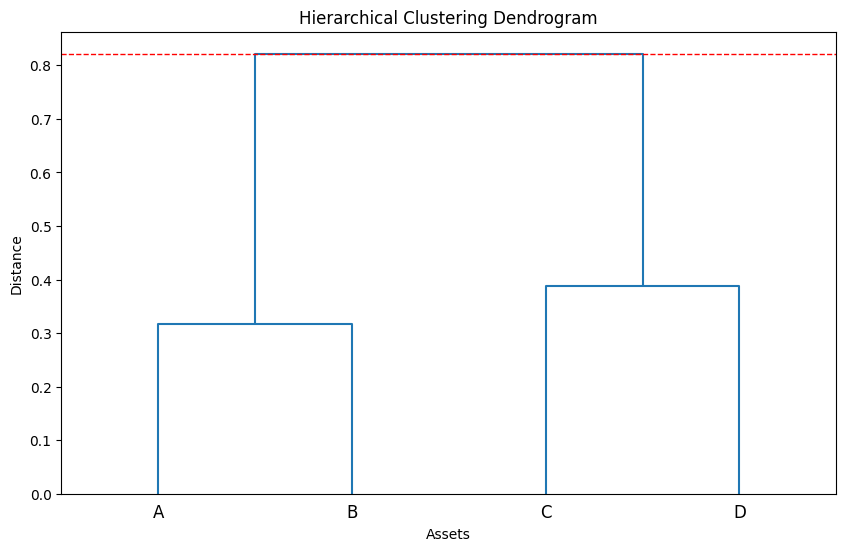


Linkage Matrix:
[cluster1, cluster2, distance, number of original observations]
[[0.       1.       0.316228 2.      ]
 [2.       3.       0.387298 2.      ]
 [4.       5.       0.821584 4.      ]]


In [ ]:
# Distance matrix
dist_mat = corr_to_dist(corr)
dist_df = pd.DataFrame(dist_mat, index=asset_names, columns=asset_names)

print("Distance Matrix:")
print(dist_df)

# Hierarchical clustering using single linkage
dist_condensed = squareform(dist_mat, checks=False)
linkage_matrix = linkage(dist_condensed, method='single')#average, complete, ward

# Plot dendrogram
plt.figure(figsize=(10, 6))
dendrogram(linkage_matrix, labels=asset_names, color_threshold=0)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Assets')
plt.ylabel('Distance')
plt.axhline(y=linkage_matrix[-1, 2], color='r', linestyle='--', linewidth=1)
plt.show()

print("\nLinkage Matrix:")
print("[cluster1, cluster2, distance, number of original observations]")
print(linkage_matrix)

## Top-Level Split Factor

Calculate the split factor for the first division (root -> {A,B} vs {C,D})

In [16]:
# Get leaf order from dendrogram
dend = dendrogram(linkage_matrix, labels=asset_names, no_plot=True)
order_leaves = dend['leaves']

print(f"Leaf order: {[asset_names[i] for i in order_leaves]}")

# Identify the first split
n = len(order_leaves)
k = n // 2
left_idx = order_leaves[:k]
right_idx = order_leaves[k:]

print(f"Left cluster indices: {left_idx} -> {[asset_names[i] for i in left_idx]}")
print(f"Right cluster indices: {right_idx} -> {[asset_names[i] for i in right_idx]}")

# Calculate cluster variances
v_left = cluster_var(cov_mat, left_idx)
v_right = cluster_var(cov_mat, right_idx)

print(f"\nVariance of left cluster (A,B): {v_left:.6f}")
print(f"Variance of right cluster (C,D): {v_right:.6f}")

# Split factor: allocate inversely to cluster variances
alpha_left = 1 - v_left / (v_left + v_right)
alpha_right = 1 - alpha_left

print(f"\nTop-level split factor:")
print(f"  Left cluster (A,B): {alpha_left*100:.2f}%")
print(f"  Right cluster (C,D): {alpha_right*100:.2f}%")

# Within-Cluster Splits
print(f"\nWithin-Cluster Allocations:")
print(f"  Cluster 1 (A vs B): Each gets ~{alpha_left/2*100:.2f}%")
print(f"  Cluster 2 (C vs D): Each gets ~{alpha_right/2*100:.2f}%")

Leaf order: ['A', 'B', 'C', 'D']
Left cluster indices: [0, 1] -> ['A', 'B']
Right cluster indices: [2, 3] -> ['C', 'D']

Variance of left cluster (A,B): 0.036000
Variance of right cluster (C,D): 0.012240

Top-level split factor:
  Left cluster (A,B): 25.37%
  Right cluster (C,D): 74.63%

Within-Cluster Allocations:
  Cluster 1 (A vs B): Each gets ~12.69%
  Cluster 2 (C vs D): Each gets ~37.31%


## Full HRP Algorithm

Implement the complete Hierarchical Risk Parity algorithm with recursive bisection.

In [17]:
def hrp_weights(cov_full, corr_full):
    """
    Hierarchical Risk Parity portfolio weights.
    
    Parameters:
    -----------
    cov_full : np.ndarray
        Covariance matrix
    corr_full : np.ndarray
        Correlation matrix
    
    Returns:
    --------
    np.ndarray
        Portfolio weights
    """
    # 1) Hierarchical clustering on correlation distances
    dist_mat = corr_to_dist(corr_full)
    dist_condensed = squareform(dist_mat, checks=False)
    linkage_matrix = linkage(dist_condensed, method='single')
    
    # Get leaf order (quasi-diagonalization)
    dend = dendrogram(linkage_matrix, no_plot=True)
    order_leaves = dend['leaves']
    
    # Reorder covariance by leaf order
    cov_ordered = cov_full[np.ix_(order_leaves, order_leaves)]
    
    n = cov_ordered.shape[0]
    weights = np.ones(n)  # Start with equal weights, will be scaled multiplicatively
    
    # List of clusters to process (start with all assets)
    clusters = [list(range(n))]
    
    # Recursive bisection until we reach individual leaves
    while clusters:
        new_clusters = []
        
        for cluster in clusters:
            if len(cluster) <= 1:
                continue
            
            # Split cluster into two halves
            k = len(cluster) // 2
            left = cluster[:k]
            right = cluster[k:]
            
            # Calculate cluster variances
            v_left = cluster_var(cov_ordered, left)
            v_right = cluster_var(cov_ordered, right)
            
            # Split factor: allocate inversely to cluster variances
            alpha = 1 - v_left / (v_left + v_right)
            
            # Update weights multiplicatively
            weights[left] *= alpha
            weights[right] *= (1 - alpha)
            
            # Add sub-clusters to process in next iteration
            new_clusters.extend([left, right])
        
        clusters = new_clusters
    
    # Map weights back to original asset order
    w_full = np.zeros(n)
    w_full[order_leaves] = weights
    
    # Normalize (numerical safety)
    w_full = w_full / np.sum(w_full)
    
    return w_full

## Run HRP and Display Results

In [18]:
# Calculate HRP weights
w = hrp_weights(cov_mat, corr)
w_series = pd.Series(w, index=asset_names)

print("HRP Portfolio Weights:")
print(w_series)
print(f"\nSum of weights: {w.sum():.6f}")

# Display as percentages
print("\nWeights (%)")
for asset, weight in w_series.items():
    print(f"  {asset}: {weight*100:.2f}%")

HRP Portfolio Weights:
A    0.126866
B    0.126866
C    0.373134
D    0.373134
dtype: float64

Sum of weights: 1.000000

Weights (%)
  A: 12.69%
  B: 12.69%
  C: 37.31%
  D: 37.31%


## Visualize Portfolio Weights

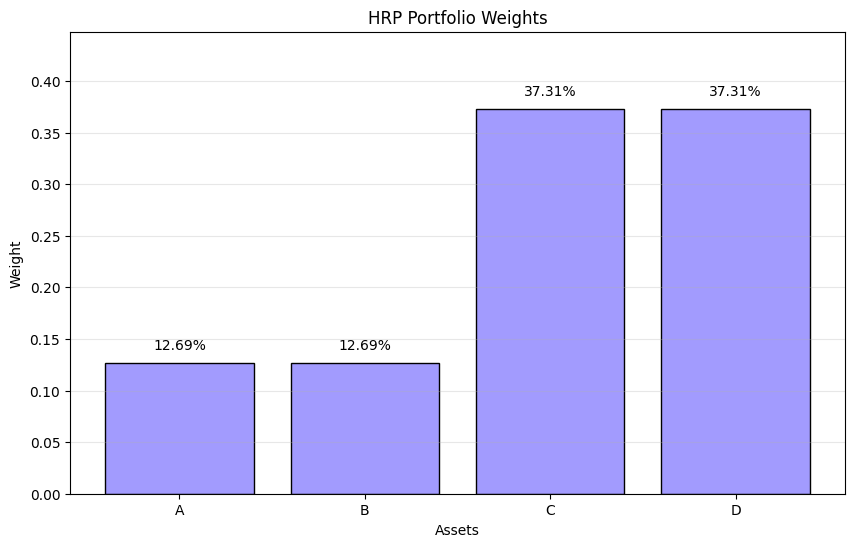

In [19]:
# Bar plot of weights
plt.figure(figsize=(10, 6))
plt.bar(asset_names, w, color='#A29BFE', edgecolor='black')
plt.xlabel('Assets')
plt.ylabel('Weight')
plt.title('HRP Portfolio Weights')
plt.ylim(0, max(w) * 1.2)
for i, (asset, weight) in enumerate(zip(asset_names, w)):
    plt.text(i, weight + 0.01, f'{weight*100:.2f}%', ha='center', va='bottom')
plt.grid(axis='y', alpha=0.3)
plt.show()

## Portfolio Risk Contribution Analysis

Portfolio Volatility: 0.104652
Portfolio Variance: 0.010952

Risk Contributions:
     Weight  Volatility       MCR       CCR     Risk %
A  0.126866        0.20  0.011821  0.001500  13.692946
B  0.126866        0.20  0.013612  0.001727  15.767635
C  0.373134        0.12  0.010657  0.003976  36.307054
D  0.373134        0.12  0.010048  0.003749  34.232365


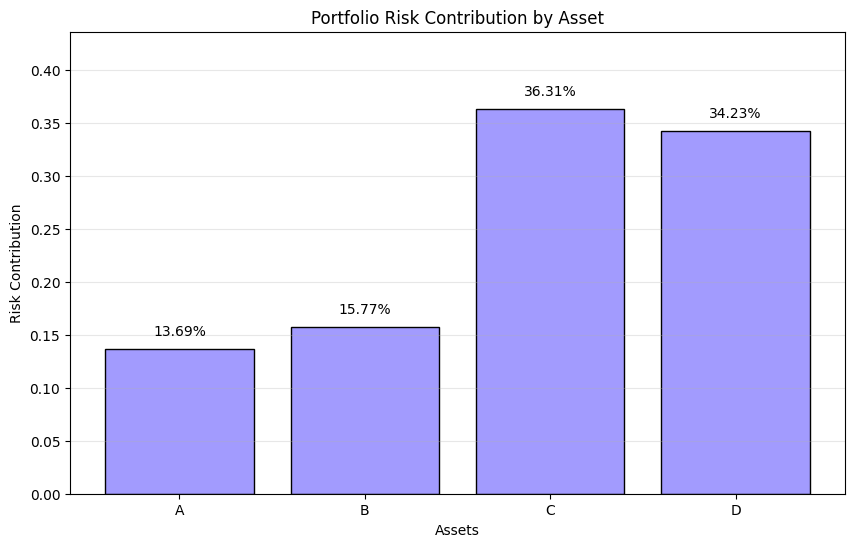

In [20]:
# Calculate portfolio variance and risk contributions
portfolio_var = w @ cov_mat @ w
portfolio_vol = np.sqrt(portfolio_var)

# Marginal contribution to risk (MCR)
mcr = cov_mat @ w

# Component contribution to risk (CCR) = weight * MCR
ccr = w * mcr

# Percentage contribution to risk
pcr = ccr / portfolio_var

print(f"Portfolio Volatility: {portfolio_vol:.6f}")
print(f"Portfolio Variance: {portfolio_var:.6f}")
print("\nRisk Contributions:")

risk_contrib_df = pd.DataFrame({
    'Weight': w,
    'Volatility': vol,
    'MCR': mcr,
    'CCR': ccr,
    'Risk %': pcr * 100
}, index=asset_names)

print(risk_contrib_df)

# Visualize risk contributions
plt.figure(figsize=(10, 6))
plt.bar(asset_names, pcr, color='#A29BFE', edgecolor='black')
plt.xlabel('Assets')
plt.ylabel('Risk Contribution')
plt.title('Portfolio Risk Contribution by Asset')
plt.ylim(0, max(pcr) * 1.2)
for i, (asset, risk) in enumerate(zip(asset_names, pcr)):
    plt.text(i, risk + 0.01, f'{risk*100:.2f}%', ha='center', va='bottom')
plt.grid(axis='y', alpha=0.3)
plt.show()